<a href="https://colab.research.google.com/github/mrokonuzzaman040/Assignment-4/blob/main/Brain_Tumor_Classification_and_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow opencv-python-headless numpy matplotlib scikit-learn

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Path to the dataset on Google Drive
path_to_training = '/content/drive/My Drive/Dataset/Training'
path_to_testing = '/content/drive/My Drive/Dataset/Testing'

Mounted at /content/drive


In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import preprocess_input
import cv2

In [4]:
# Image Data Generators
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Create train and test generators
train_generator = train_datagen.flow_from_directory(
    path_to_training,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    path_to_testing,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)


Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


In [5]:
# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Combine base model and custom layers
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,3

 Total params: 14,847,044 (56.64 MB)

 Trainable params: 132,356 (517.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8005 - loss: 0.5106 - val_accuracy: 0.6396 - val_loss: 1.5808
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 52s 996ms/step - accuracy: 0.8431 - loss: 0.4272 - val_accuracy: 0.6929 - val_loss: 1.3658
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 80s 988ms/step - accuracy: 0.8696 - loss: 0.3520 - val_accuracy: 0.7056 - val_loss: 1.4529
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 83s 986ms/step - accuracy: 0.8589 - loss: 0.3936 - val_accuracy: 0.6980 - val_loss: 1.1912
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.8916 - loss: 0.2972 - val_accuracy: 0.6675 - val_loss: 1.7011
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 51s 976ms/step - accuracy: 0.8907 - loss: 0.2774 - val_accuracy: 0.7259 - val_loss: 1.3901
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.9062 - loss: 0.2621 - val_accuracy: 0.7513 - val_loss: 1.4697
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.9146 - loss: 0.2361 - val_accuracy: 0.7437

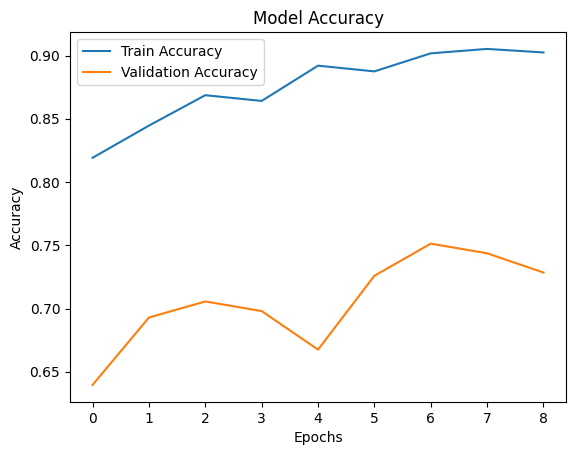

In [7]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=20,
    callbacks=[early_stopping]
)

# Step 6: Plot Training and Validation Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()


In [8]:
# Step 7: Save the Trained Model
model.save('/content/drive/My Drive/brain_tumor_model.h5')

print("Model saved successfully!")

Model saved successfully!


In [9]:
# Step 8: Tumor Detection and Region Boundary Visualization
def detect_and_draw_boundary(image_path, model, class_indices):
    # Load and preprocess the image
    image = cv2.imread(image_path)
    image_resized = cv2.resize(image, (224, 224))
    image_array = np.expand_dims(image_resized, axis=0)
    image_preprocessed = preprocess_input(image_array)

    # Predict the tumor type
    prediction = model.predict(image_preprocessed)
    tumor_class = np.argmax(prediction)
    tumor_label = list(class_indices.keys())[tumor_class]

    # Visualize boundaries using Canny edge detection
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, threshold1=50, threshold2=150)

    # Overlay edges on the image
    overlay = image.copy()
    overlay[edges != 0] = [0, 255, 0]

    # Display the image
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title(f'Tumor Class: {tumor_label}')
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


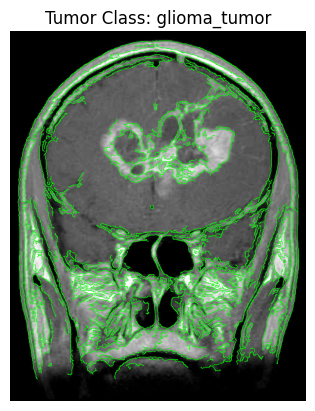

In [10]:
# Test the function
test_image = '/content/drive/My Drive/Dataset/Testing/glioma_tumor/image-1.jpg'
detect_and_draw_boundary(test_image, model, train_generator.class_indices)

In [11]:
# Step 9: Evaluate the Model
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 315ms/step - accuracy: 0.6935 - loss: 1.2055
Test Loss: 1.1912484169006348
Test Accuracy: 0.6979695558547974
